In [182]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [2]:
db = dm.read_db(base='prices_global.pkl', add=['prices_global_gwx.pkl'])
db_kr = dm.read_db(base='prices_kr.pkl', add=['prices_global.pkl'])

# Multiasset model

In [172]:
multiasset = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=10, 
    assets=setting.assets_multiasset, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=24, 
    follow_trend=None, #(20,60), 
    follow_trend_market=None, #(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_AGG', 
    start='2002-12-31', 
    losscut=0.05, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

26.42490839958191


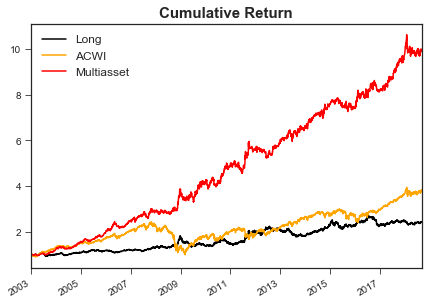

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [173]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum(strats, names=names, color=color, logy=False)

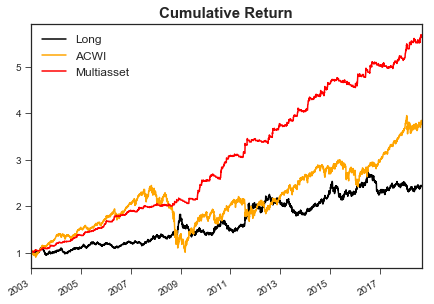

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [142]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum(strats, names=names, color=color, logy=False)

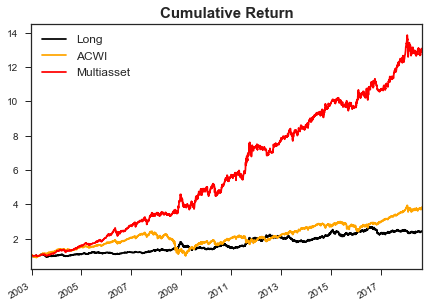

In [460]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum(strats, names=names, color=color, logy=False)

In [171]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
EU,2.92,3946,7.02,22.95,0.31,-63.27,13.24,17.69,0.78,1.15,32.00,57.75,1.06,11.41
Developed,3.07,3946,7.38,21.57,0.34,-61.04,13.38,15.66,0.88,1.10,29.27,60.43,0.98,16.82
BND_DevFloat_usd,1.33,3757,1.91,2.31,0.83,-7.30,1.81,0.68,2.44,0.01,12.26,83.62,0.63,85.93
Smallcap_xUS,5.16,3946,10.95,19.53,0.56,-63.25,15.94,14.19,1.07,0.93,26.08,61.50,1.09,19.00
DualMomentum,5.57,3946,11.49,5.41,2.12,-6.26,11.48,5.01,2.21,0.04,2.60,64.71,2.32,93.85


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [131]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
EU,2.92,3946,7.02,22.95,0.31,-63.27,13.24,17.69,0.78,1.15,32.00,57.75,1.06,11.41
Developed,3.07,3946,7.38,21.57,0.34,-61.04,13.38,15.66,0.88,1.10,29.27,60.43,0.98,16.82
BND_DevFloat_usd,1.33,3757,1.91,2.31,0.83,-7.30,1.81,0.68,2.44,0.01,12.26,83.62,0.63,85.93
Smallcap_xUS,5.16,3946,10.95,19.53,0.56,-63.25,15.94,14.19,1.07,0.93,26.08,61.50,1.09,19.00
DualMomentum,6.65,3946,12.76,9.04,1.41,-15.19,13.70,7.74,1.45,0.04,6.33,62.57,1.65,91.26


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [174]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
EU,2.92,3946,7.02,22.95,0.31,-63.27,13.24,17.69,0.78,1.15,32.00,57.75,1.06,11.41
Developed,3.07,3946,7.38,21.57,0.34,-61.04,13.38,15.66,0.88,1.10,29.27,60.43,0.98,16.82
BND_DevFloat_usd,1.33,3757,1.91,2.31,0.83,-7.30,1.81,0.68,2.44,0.01,12.26,83.62,0.63,85.93
Smallcap_xUS,5.16,3946,10.95,19.53,0.56,-63.25,15.94,14.19,1.07,0.93,26.08,61.50,1.09,19.00
DualMomentum,9.89,3946,15.63,11.72,1.33,-14.58,15.55,9.99,1.32,0.10,2.49,65.24,1.49,93.14


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [457]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_GlobalTip_loc,1.10,2634,0.89,9.99,0.09,-29.60,2.91,8.38,0.34,0.19,32.03,58.06,0.81,33.53
NatGas,0.01,2866,-30.79,40.81,-0.75,-98.99,-30.88,39.87,-0.79,0.21,79.02,38.52,0.86,89.31
BND_US_Long,2.42,3946,5.77,13.43,0.43,-26.58,6.25,12.66,0.53,-0.28,24.43,55.08,1.22,94.34
Latam,5.79,3946,11.78,32.11,0.37,-67.48,17.97,26.46,0.66,1.41,35.98,56.68,1.18,-35.37
DualMomentum,12.94,3946,17.62,13.54,1.30,-19.40,16.73,11.80,1.35,0.15,1.60,65.78,1.56,93.36


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


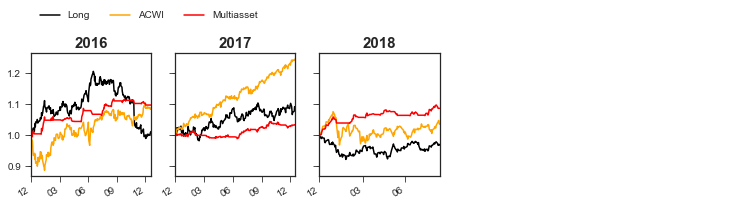

In [148]:
multiasset.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

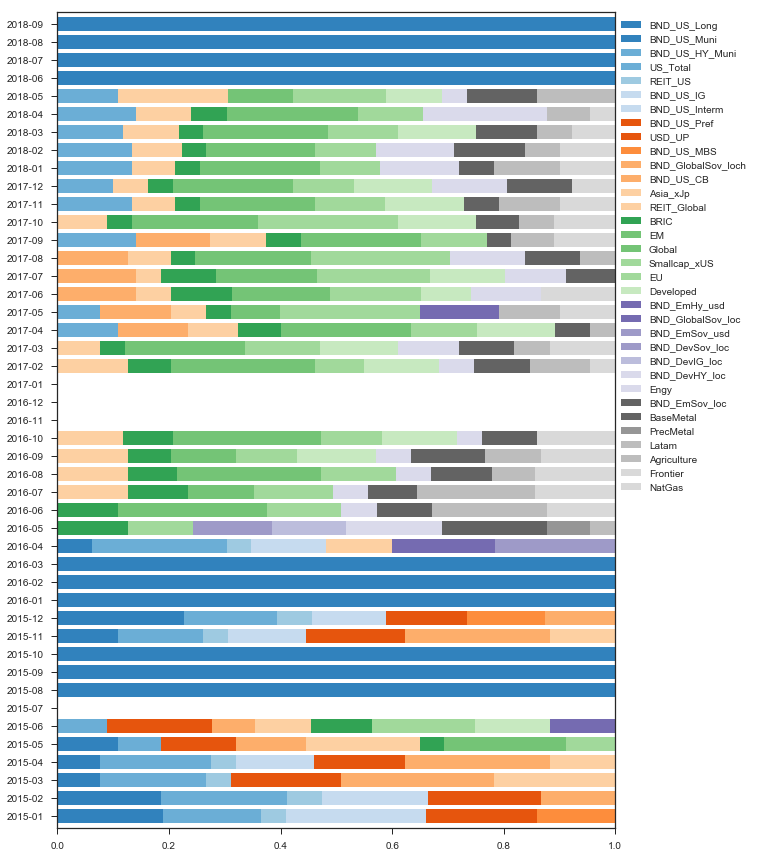

In [462]:
multiasset.plot_weight([2015, 2018])

# Global equity allocation model

In [183]:
geam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=10, 
    assets=setting.assets_global_eq, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_AGG', 
    start='2002-12-31', 
    losscut=0.05, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

24.66315197944641


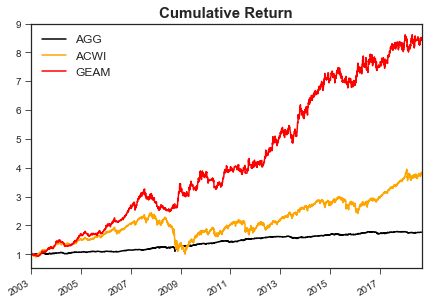

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [184]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


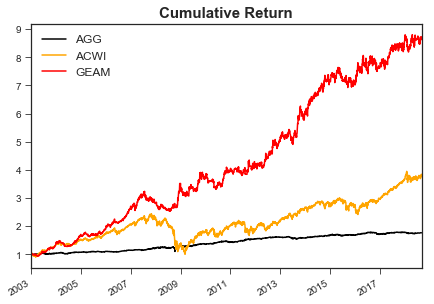

In [180]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

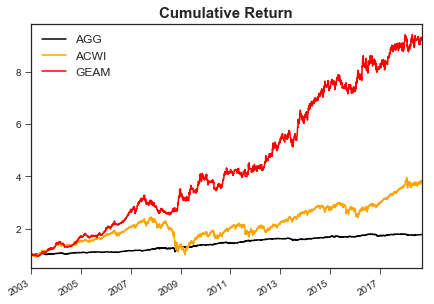

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [176]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

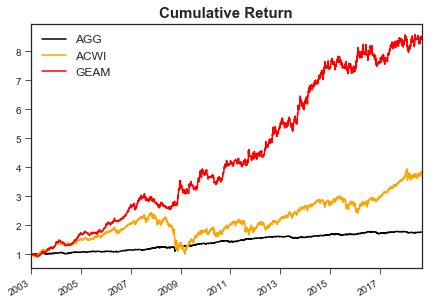

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [133]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

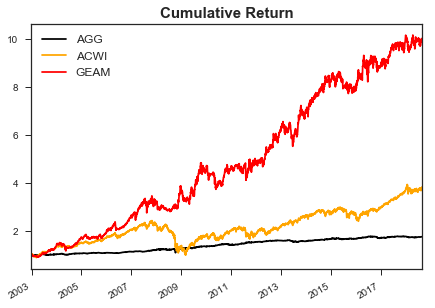

In [481]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [177]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
UK,2.42,3946,5.76,22.87,0.25,-64.01,11.62,17.47,0.70,1.10,31.16,58.29,1.00,12.27
Argentina,0.94,1953,-0.82,24.99,-0.03,-51.97,5.65,23.58,0.25,1.06,41.55,55.43,0.89,-62.04
Australia,4.88,3946,10.57,27.15,0.39,-66.98,14.66,18.84,0.74,1.23,27.78,60.96,1.01,26.28
Sweden,5.60,3946,11.53,29.78,0.39,-68.07,16.94,22.87,0.76,1.37,33.22,55.61,1.31,23.13
DualMomentum,9.24,3946,15.13,12.90,1.17,-22.79,15.46,12.74,1.22,0.11,8.47,58.29,1.72,93.67


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [185]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
UK,2.42,3946,5.76,22.87,0.25,-64.01,11.62,17.47,0.70,1.10,31.16,58.29,1.00,12.27
Argentina,0.94,1953,-0.82,24.99,-0.03,-51.97,5.65,23.58,0.25,1.06,41.55,55.43,0.89,-62.04
Australia,4.88,3946,10.57,27.15,0.39,-66.98,14.66,18.84,0.74,1.23,27.78,60.96,1.01,26.28
Sweden,5.60,3946,11.53,29.78,0.39,-68.07,16.94,22.87,0.76,1.37,33.22,55.61,1.31,23.13
DualMomentum,8.43,3946,14.46,12.99,1.11,-23.96,14.82,12.74,1.12,0.11,9.44,58.29,1.65,92.75


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [482]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Italy,1.51,3946,2.66,28.21,0.09,-70.38,8.66,23.36,0.40,1.27,39.25,55.08,0.98,-113.57
Indonesia,8.79,3946,14.77,29.99,0.49,-72.14,17.52,28.43,0.68,0.67,28.00,61.50,1.05,37.32
BND_US_Long,2.42,3946,5.77,13.43,0.43,-26.58,6.25,12.66,0.53,-0.28,24.43,55.08,1.22,94.34
Turkey,2.76,3946,6.65,39.91,0.17,-76.62,9.22,33.78,0.28,1.35,41.41,56.68,1.01,-96.08
DualMomentum,9.93,3946,15.66,16.32,0.96,-22.79,15.02,15.36,1.02,0.24,9.76,60.43,1.47,92.78


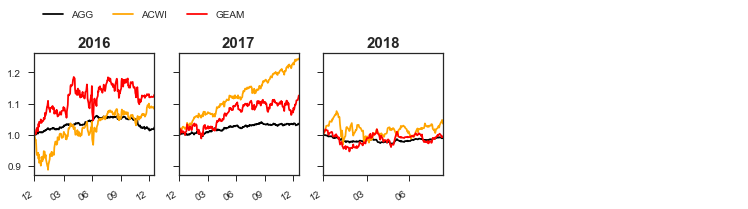

In [483]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

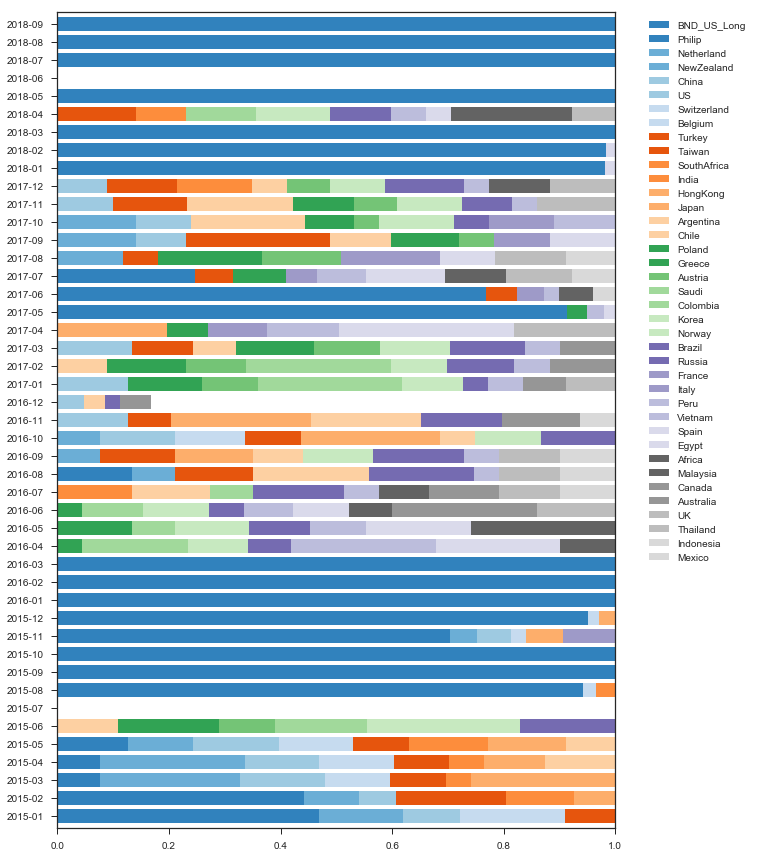

In [484]:
geam.plot_weight([2015, 2018])

# Global sector allocation model

In [135]:
gsam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=10, 
    assets=setting.assets_global_sector, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_AGG', 
    start='2002-12-31', 
    losscut=0.05,
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

32.40629172325134


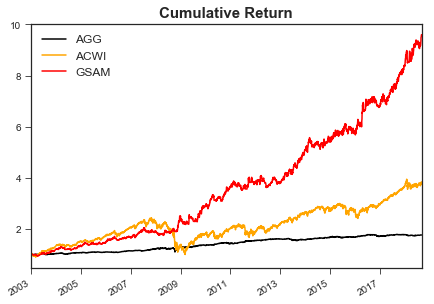

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [136]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum(strats, names=names, color=color, logy=False)

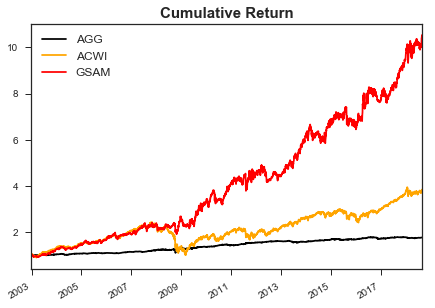

In [493]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum(strats, names=names, color=color, logy=False)

In [137]:
gsam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
MLP,5.27,3946,11.10,20.18,0.55,-53.06,10.98,13.80,0.98,0.61,26.94,63.64,1.04,55.28
RegionalBank,2.65,3828,6.56,29.82,0.22,-68.54,8.12,20.40,0.41,1.14,29.25,58.56,1.00,19.00
Transportation,5.82,3946,11.81,22.99,0.51,-60.39,16.65,18.49,0.89,0.96,21.96,60.96,1.09,84.30
CapitalMarket,2.31,3828,5.61,29.43,0.19,-74.00,10.85,19.50,0.54,1.30,32.83,60.22,0.88,-3.41
DualMomentum,9.60,3946,15.41,12.54,1.23,-14.61,15.08,11.72,1.31,0.16,3.68,62.57,1.55,98.94


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [487]:
gsam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Uranium,0.15,1969,-21.41,33.03,-0.65,-90.52,-20.23,30.10,-0.70,1.27,82.91,40.22,1.03,80.83
ConsumerGoods,4.02,3946,9.21,14.45,0.64,-42.64,11.48,11.49,0.99,0.64,13.01,63.10,1.12,91.95
Bio,7.60,3946,13.72,23.58,0.58,-39.25,11.61,21.40,0.57,0.82,25.53,59.36,1.21,84.94
Timber,3.52,3946,8.30,22.09,0.38,-70.67,12.71,15.63,0.74,1.02,27.05,64.17,0.84,33.77
DualMomentum,10.53,3946,16.09,17.10,0.94,-20.56,16.36,14.72,1.05,0.42,6.87,63.64,1.31,98.29


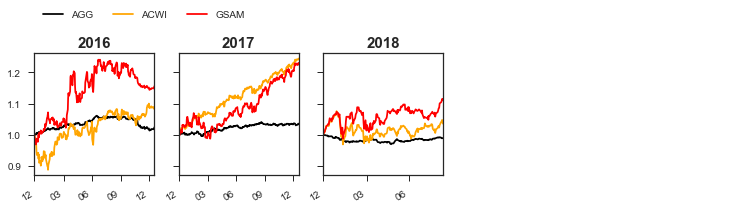

In [494]:
gsam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

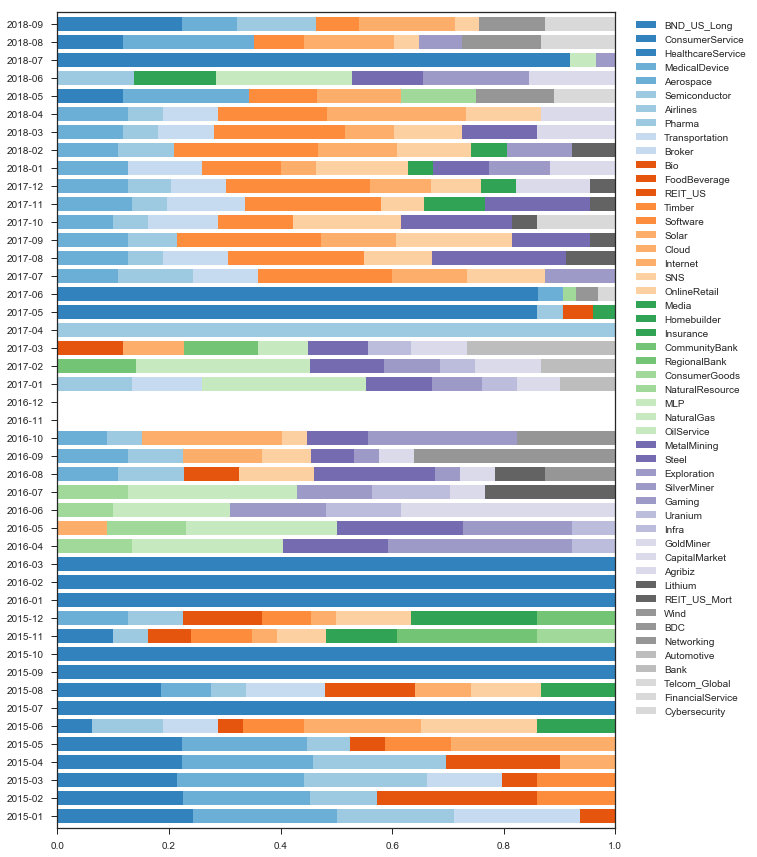

In [490]:
gsam.plot_weight([2015, 2018])

# Global fixed-income allocation model

In [138]:
gfam = q.Backtester(
    setting.base_params(db), 
    w_type='ranky2', 
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_fi, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=False, 
    #sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='BND_US_AGG', #'BND_GlobalSov_loch', #'BND_US_AGG', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

25.370370626449585


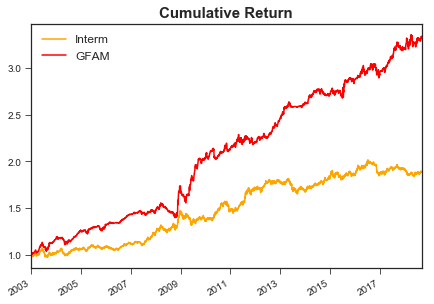

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [139]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Interm', 'GFAM']
color = ['orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

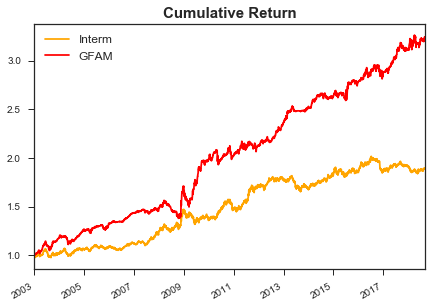

In [780]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Interm', 'GFAM']
color = ['orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

In [140]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_GlobalSov_loc,1.25,2754,2.02,8.74,0.23,-16.86,1.33,7.93,0.17,0.11,41.00,59.23,0.86,-10.83
BND_DevFloat_usd,1.33,3757,1.91,2.31,0.83,-7.30,1.81,0.68,2.44,0.01,12.26,83.62,0.63,85.93
BND_US_Long,2.42,3946,5.77,13.43,0.43,-26.58,6.25,12.66,0.53,-0.28,24.43,55.08,1.22,94.34
BND_EmHy_usd,3.33,3946,7.92,7.03,1.13,-32.10,8.04,6.47,1.47,0.13,17.77,68.98,0.89,94.58
DualMomentum,3.34,3946,7.93,5.93,1.34,-10.44,6.32,5.16,1.30,0.02,2.87,66.84,1.38,96.86


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [760]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_Pref,2.10,3765,5.04,18.60,0.27,-65.55,5.15,6.05,0.89,0.55,16.75,67.98,0.75,71.75
BND_GlobalTip_loc,1.10,2634,0.89,9.99,0.09,-29.60,2.91,8.38,0.34,0.19,32.03,58.06,0.81,33.53
BND_EmSov_loc,1.17,2688,1.50,11.01,0.14,-32.01,3.96,10.20,0.36,0.28,42.31,60.63,0.76,-0.79
BND_US_Long,2.42,3946,5.77,13.43,0.43,-26.58,6.25,12.66,0.53,-0.28,24.43,55.08,1.22,94.34
DualMomentum,3.24,3946,7.74,6.25,1.24,-12.50,5.98,5.36,1.22,0.03,3.14,66.84,1.31,97.18


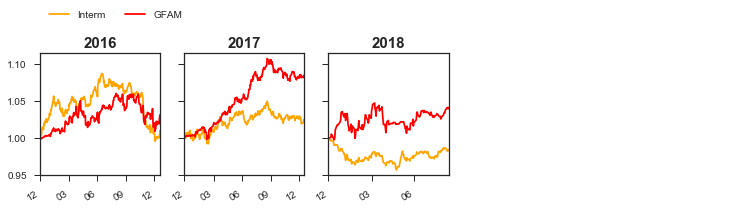

In [761]:
gfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

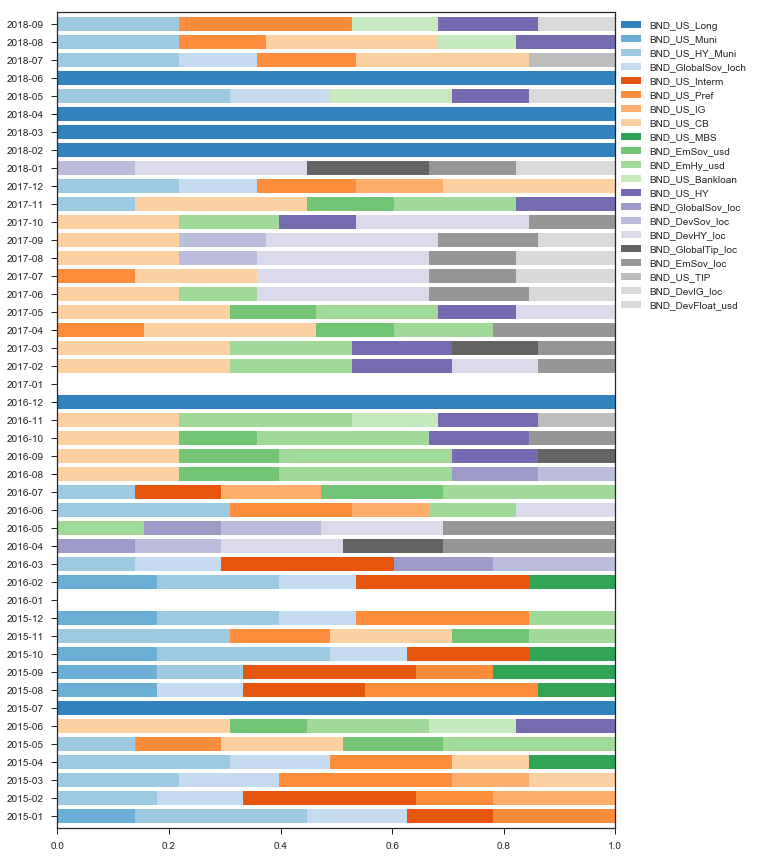

In [762]:
gfam.plot_weight([2015, 2018])

In [165]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


# Korea factor allocation model

In [166]:
kfam = q.Backtester(
    setting.base_params(db_kr), 
    w_type='inv_ranky2', # ranky2 가 더 잘나오긴 한다. ----
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_kr_factor, #|setting.assets_us_factor2, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=None, #(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='K200', 
    supporter='KTB10YL', 
    cash_equiv= 'KTB10Y', 
    #trade_assets=[('K200', {'K200L':0.5})], 
    start='2002-12-31', 
    losscut=0.01, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

24.417109966278076


In [105]:
rt = kfam.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.05]

2003-10-31   -0.053422
2005-04-30   -0.052744
2006-05-31   -0.086460
2007-01-31   -0.066637
2007-11-30   -0.108383
2008-06-30   -0.064709
2009-01-31   -0.057171
2009-02-28   -0.113213
2011-02-28   -0.066878
2011-08-31   -0.094730
Name: DualMomentum, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [117]:
rt = kfam.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.01]

2003-06-30   -0.010890
2004-01-31   -0.010082
2004-04-30   -0.010890
2005-01-31   -0.010134
2005-12-31   -0.010032
2006-03-31   -0.010890
2006-06-30   -0.010890
2006-10-31   -0.014693
2006-12-31   -0.011883
2007-01-31   -0.010890
2007-09-30   -0.010890
2007-11-30   -0.010890
2008-01-31   -0.010890
2008-02-29   -0.010890
2008-03-31   -0.010890
2008-06-30   -0.010876
2008-07-31   -0.010890
2009-06-30   -0.010029
2010-05-31   -0.010553
2011-05-31   -0.010890
2011-06-30   -0.010890
2011-08-31   -0.010890
2012-11-30   -0.010060
2013-06-30   -0.010308
2013-08-31   -0.010890
2013-11-30   -0.010890
2014-01-31   -0.013305
2014-12-31   -0.010890
2015-05-31   -0.010597
2015-06-30   -0.010890
2015-07-31   -0.010890
2016-08-31   -0.010890
2017-09-30   -0.010890
Name: DualMomentum, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [37]:
p_max_ = kfam.p_close.iloc[-6].to_frame().T.append(kfam.p_close.tail(5)).cummax(); p_max_*0.95

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,28096.25,23018.5,14672.75,9661.50,12692.00,112898.00,118047.00,8706.75,9025.00,9523.75,24861.5,8768.50,69.8155,8497.75,12568.50,10996.25,11053.25
2018-08-27,28234.00,23465.0,14710.75,9680.50,12801.25,113140.25,118341.50,8706.75,9048.75,9566.50,25051.5,8768.50,70.4900,8559.50,12701.50,10996.25,11271.75
2018-08-28,28257.75,23465.0,14786.75,9775.50,12810.75,113244.75,118745.25,8706.75,9082.00,9642.50,25270.0,8801.75,70.5280,8588.00,12706.25,11115.00,11271.75
2018-08-29,28329.00,23465.0,14801.00,9837.25,12867.75,113263.75,118754.75,8706.75,9082.00,9642.50,25270.0,8811.25,70.9460,8626.00,12768.00,11295.50,11271.75
2018-08-30,28352.75,23465.0,14801.00,9837.25,12905.75,113263.75,118754.75,8706.75,9082.00,9642.50,25270.0,8811.25,70.9460,8626.00,12810.75,11295.50,11271.75
2018-08-31,28457.25,23465.0,14801.00,9837.25,12905.75,113520.25,119571.75,8706.75,9082.00,9642.50,25270.0,8811.25,70.9460,8626.00,12891.50,11295.50,11324.00


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [36]:
p_close_ = kfam.p_close.tail(6); p_close_

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,29575.0,24230.0,15445.0,10170.0,13360.0,118840.0,124260.0,9165.0,9500.0,10025.0,26170.0,9230.0,73.49,8945.0,13230.0,11575.0,11635.0
2018-08-27,29720.0,24700.0,15485.0,10190.0,13475.0,119095.0,124570.0,9150.0,9525.0,10070.0,26370.0,9225.0,74.20,9010.0,13370.0,11565.0,11865.0
2018-08-28,29745.0,24540.0,15565.0,10290.0,13485.0,119205.0,124995.0,9155.0,9560.0,10150.0,26600.0,9265.0,74.24,9040.0,13375.0,11700.0,11785.0
2018-08-29,29820.0,24645.0,15580.0,10355.0,13545.0,119225.0,125005.0,9165.0,9555.0,10140.0,26570.0,9275.0,74.68,9080.0,13440.0,11890.0,11775.0
2018-08-30,29845.0,24545.0,15420.0,10215.0,13585.0,119160.0,124795.0,9125.0,9455.0,10030.0,26410.0,9205.0,74.04,9010.0,13485.0,11795.0,11740.0
2018-08-31,29955.0,24650.0,15475.0,10250.0,13565.0,119495.0,125865.0,9155.0,9510.0,10105.0,26440.0,9255.0,73.81,9080.0,13570.0,11770.0,11920.0


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [48]:
p_max_*0.99 < p_close_

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-27,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-28,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-29,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-30,True,True,False,False,True,True,True,True,False,False,True,True,True,True,True,True,False
2018-08-31,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,False,True


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [49]:
(p_max_*0.99 < p_close_).cummin()

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-27,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-28,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-29,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-30,True,True,False,False,True,True,True,True,False,False,True,True,True,True,True,True,False
2018-08-31,True,True,False,False,True,True,True,True,False,False,True,True,False,True,True,False,False


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


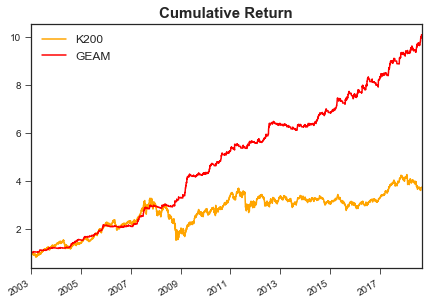

In [167]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

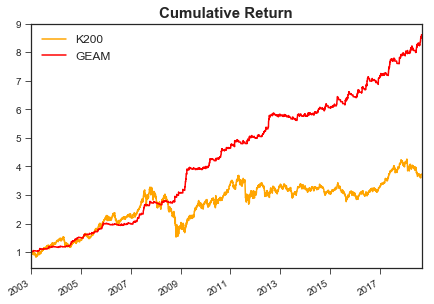

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [121]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

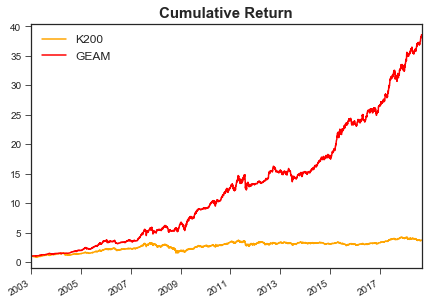

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [46]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

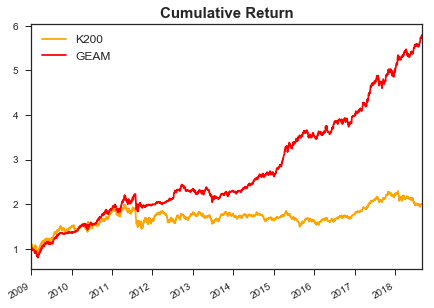

In [1141]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

In [168]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
K200L,1.54,2213,5.01,29.80,0.17,-53.96,-1.59,25.35,-0.06,0.48,52.44,57.43,0.98,-12.85
Turnaround_kr,1.61,1728,7.17,15.16,0.47,-26.82,8.19,13.45,0.62,0.26,17.17,56.41,1.12,78.71
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
DualMomentum,10.08,4064,15.28,6.31,2.42,-5.73,12.13,5.84,2.17,0.01,5.56,60.96,3.04,90.94


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [119]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
K200L,1.54,2213,5.01,29.80,0.17,-53.96,-1.59,25.35,-0.06,0.48,52.44,57.43,0.98,-12.85
Turnaround_kr,1.61,1728,7.17,15.16,0.47,-26.82,8.19,13.45,0.62,0.26,17.17,56.41,1.12,78.71
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
DualMomentum,8.62,4064,14.17,5.94,2.39,-4.52,10.86,5.36,2.04,0.01,3.22,59.36,3.23,90.47


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [85]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
K200L,1.54,2213,5.01,29.80,0.17,-53.96,-1.59,25.35,-0.06,0.48,52.44,57.43,0.98,-12.85
Turnaround_kr,1.61,1728,7.17,15.16,0.47,-26.82,8.19,13.45,0.62,0.26,17.17,56.41,1.12,78.71
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
DualMomentum,27.97,4064,22.75,9.84,2.31,-11.55,20.94,9.00,2.40,0.05,5.45,68.98,2.02,95.52


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [81]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
K200L,1.54,2213,5.01,29.80,0.17,-53.96,-1.59,25.35,-0.06,0.48,52.44,57.43,0.98,-12.85
Turnaround_kr,1.61,1728,7.17,15.16,0.47,-26.82,8.19,13.45,0.62,0.26,17.17,56.41,1.12,78.71
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
DualMomentum,36.18,4064,24.71,11.71,2.11,-16.37,23.88,10.68,2.27,0.06,5.66,70.05,1.76,95.11


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [26]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
ESG_kr,1.30,1512,4.40,10.82,0.41,-16.82,6.09,10.02,0.61,0.19,36.03,57.97,1.09,47.96
HighBeta_kr,5.07,4064,10.51,22.63,0.46,-61.10,11.26,18.50,0.53,0.35,30.54,59.89,1.08,57.07
LowVol_kr,7.60,4064,13.29,16.74,0.79,-43.38,11.72,14.36,0.85,0.25,20.21,58.29,1.41,62.21
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
DualMomentum,38.60,4064,25.21,14.63,1.72,-21.14,23.71,13.58,2.08,0.10,7.18,72.19,1.39,91.54


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


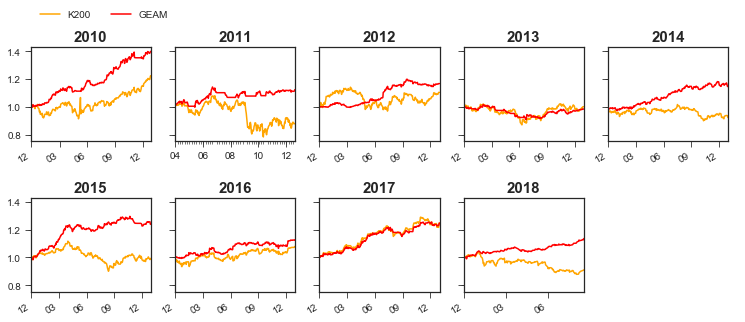

In [87]:
kfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

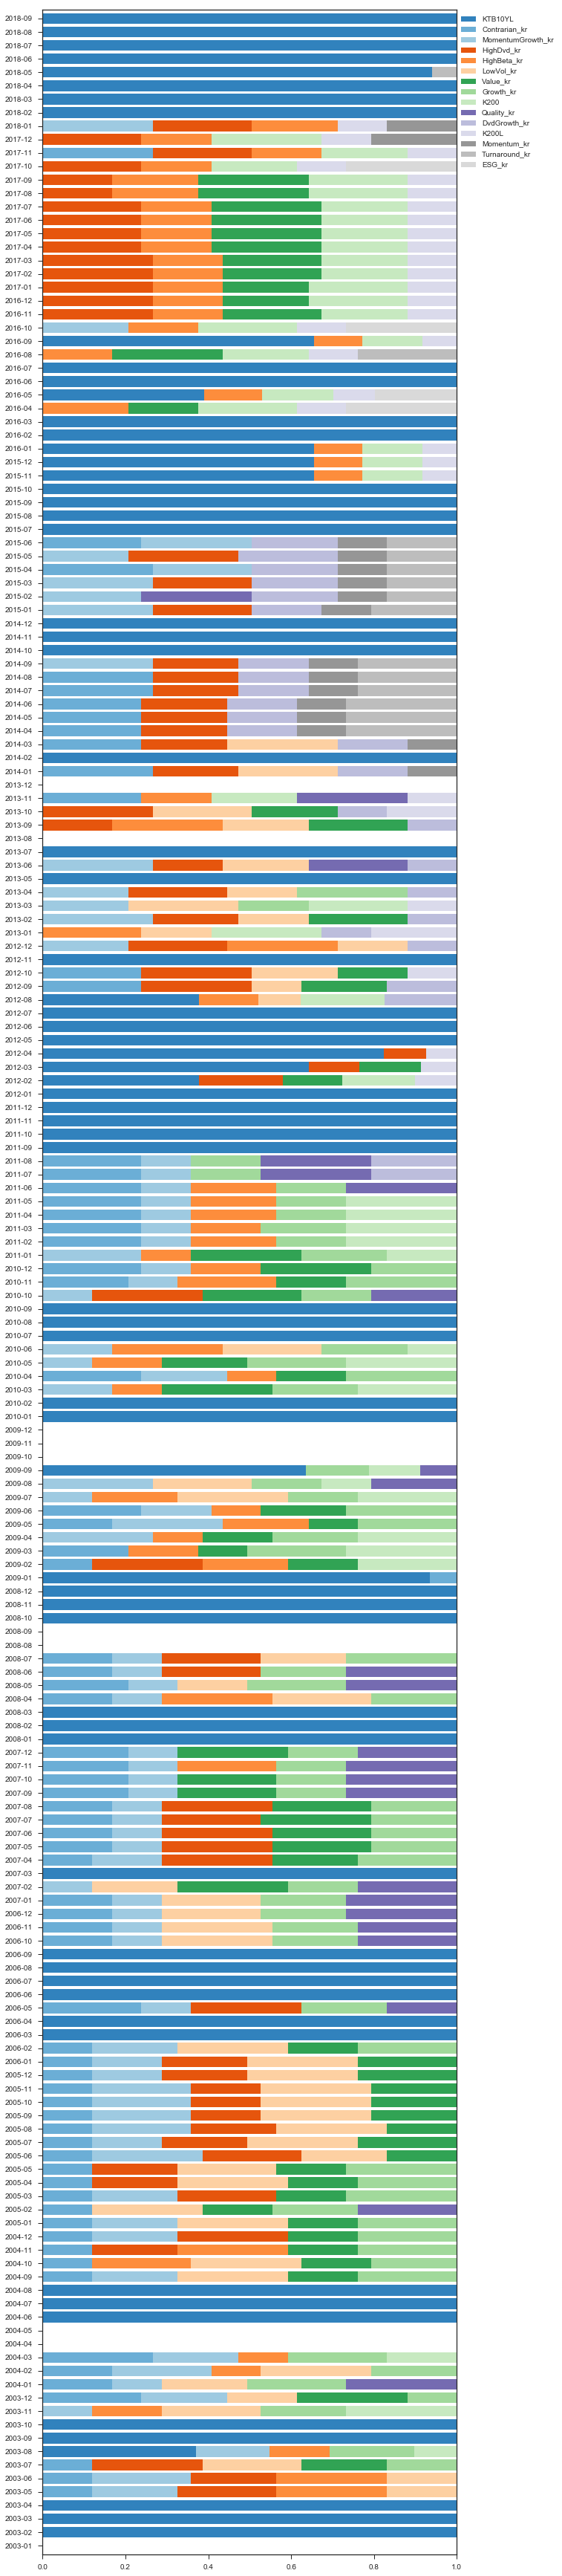

In [54]:
kfam.plot_weight([2003, 2018])

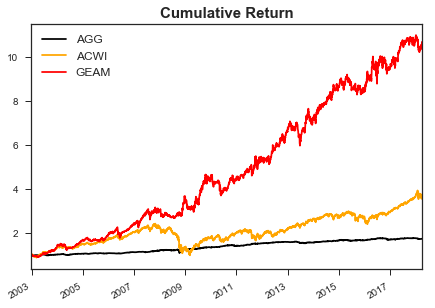

In [140]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

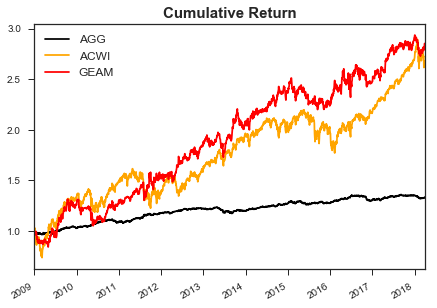

In [79]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [137]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
NewZealand,2.59,3839,6.39,12.28,0.52,-23.20,0.00,11.17,0.82,0.25,8.64,31.32,1.06,64.02
Russia,0.75,2751,-2.62,43.80,-0.06,-81.89,0.06,35.03,0.00,1.65,50.00,49.23,1.14,19.80
Chile,6.02,3839,12.40,23.04,0.54,-60.18,15.28,19.04,0.71,0.81,38.69,55.49,1.31,-45.83
Greece,0.70,1587,-5.37,43.46,-0.12,-77.39,10.20,40.40,0.25,1.65,43.57,51.35,1.04,28.94
DualMomentum,10.69,3839,16.69,15.32,1.09,-21.29,16.64,14.74,1.16,0.20,7.41,63.19,1.43,96.00


In [18]:
s1=pd.Series([1,2,3], index=['a','b','c'])
df=pd.DataFrame([[1,2,3],[4,5,6]], columns=['a','b','c']);df

,a,b,c
0,1,2,3
1,4,5,6


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [24]:
s1.to_frame().T.append(df)

,a,b,c
0,1,2,3
0,1,2,3
1,4,5,6


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
